In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from typing import Iterable

# HookedTransformer

* [TransformerLens - Tutorial - Trains HookedTransformer from Scratch](https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/No_Position_Experiment.ipynb)

```python
import transformers

# note: it's probably easier to just operate on tokens outside of the model,
#       that'll also make it clearer where tokenizer is used
#
# okay wrapping a pretrained tokenizer *can* be done:
# - https://huggingface.co/learn/nlp-course/chapter6/8#building-a-bpe-tokenizer-from-scratch
# - but none of the models support just naive encoding
#   - https://huggingface.co/docs/tokenizers/api/models#tokenizers.models.BPE
class HookedTransformer:
    cfg: HookedTransformerConfig

    # note: actually does an `isinstance` check in the constructor
    tokenizer: transformers.PreTrainedTokenizerBase | None
```

In [3]:
import transformer_lens

from jaxtyping import Int64, Float32

import numpy as np
import plotly.express as px
import plotly.io as pio

import torch
import torch.utils.data

In [4]:
# plotting code copied over from transformer_lens tutorial notebook


def line(tensor: torch.Tensor, line_labels=None, yaxis="", xaxis="", **kwargs):
    tensor = transformer_lens.utils.to_numpy(tensor)
    labels = {"y": yaxis, "x": xaxis}
    fig = px.line(tensor, labels=labels, **kwargs)
    if line_labels:
        for c, label in enumerate(line_labels):
            fig.data[c].name = label
    fig.show()


def imshow(tensor: torch.Tensor, yaxis="", xaxis="", **kwargs):
    tensor = transformer_lens.utils.to_numpy(tensor)
    plot_kwargs = {
        "color_continuous_scale": "RdBu",
        "color_continuous_midpoint": 0.0,
        "labels": {"x": xaxis, "y": yaxis},
    }
    plot_kwargs.update(kwargs)
    px.imshow(tensor, **plot_kwargs).show()

In [5]:
device = transformer_lens.utils.get_device()

print(f"Using device: {device}")

Using device: mps


### Setup Sample Generator

In [6]:
import string
import itertools
import more_itertools


class SpecialToken:
    # note: as assume a BOS token because transformerlens expects it
    BOS = "<"
    # we use a EOS token for convenience
    EOS = ">"


# TODO(bschoen): Allow this to generalize in the future
def generate_sample() -> Iterable[str]:
    """Generate palindrom samples like `<abc|cba>`."""

    # Generate all combinations of lowercase letters
    characters = string.ascii_lowercase

    # note: chosen arbitrarily
    length = 3

    for combination in itertools.product(characters, repeat=length):

        combination_str = "".join(combination)
        reversed_str = "".join(reversed(combination_str))

        yield SpecialToken.BOS + combination_str + "|" + reversed_str + SpecialToken.EOS


# show a few examples
[x for x in more_itertools.take(10, generate_sample())]

['<aaa|aaa>',
 '<aab|baa>',
 '<aac|caa>',
 '<aad|daa>',
 '<aae|eaa>',
 '<aaf|faa>',
 '<aag|gaa>',
 '<aah|haa>',
 '<aai|iaa>',
 '<aaj|jaa>']

### Setup Tokenizer

In [7]:
from gpt_from_scratch.naive_tokenizer import NaiveTokenizer

vocab = string.ascii_lowercase + "|" + SpecialToken.BOS + SpecialToken.EOS

tokenizer = NaiveTokenizer.from_text(vocab)

In [8]:
from gpt_from_scratch import tokenizer_utils

# test tokenizer
input_text = "<abc|cba><bdd|ddb>"
tokenizer_utils.show_token_mapping(tokenizer, input_text)

Input:		<abc|cba><bdd|ddb>
Tokenized:	<abc|cba><bdd|ddb>
Token ID | Token Bytes | Token String
---------+-------------+--------------
       0 | 3C | '<'
          <abc|cba><bdd|ddb>
          U+003C LESS-THAN SIGN (1 bytes: 3C)
       2 | 61 | 'a'
          <abc|cba><bdd|ddb>
          U+0061 LATIN SMALL LETTER A (1 bytes: 61)
       3 | 62 | 'b'
          <abc|cba><bdd|ddb>
          U+0062 LATIN SMALL LETTER B (1 bytes: 62)
       4 | 63 | 'c'
          <abc|cba><bdd|ddb>
          U+0063 LATIN SMALL LETTER C (1 bytes: 63)
      28 | 7C | '|'
          <abc|cba><bdd|ddb>
          U+007C VERTICAL LINE (1 bytes: 7C)
       4 | 63 | 'c'
          <abc|cba><bdd|ddb>
          U+0063 LATIN SMALL LETTER C (1 bytes: 63)
       3 | 62 | 'b'
          <abc|cba><bdd|ddb>
          U+0062 LATIN SMALL LETTER B (1 bytes: 62)
       2 | 61 | 'a'
          <abc|cba><bdd|ddb>
          U+0061 LATIN SMALL LETTER A (1 bytes: 61)
       1 | 3E | '>'
          <abc|cba><bdd|ddb>
          U+003E GREAT

### Setup Model

In [9]:
# now we know our vocab size from our sample generation

cfg = transformer_lens.HookedTransformerConfig(
    n_layers=1,
    d_model=12,
    d_head=12,
    # The number of attention heads.
    # If not specified, will be set to d_in // d_head.
    # (This is represented by a default value of -1)
    n_heads=1,
    # The dimensionality of the feedforward mlp network.
    # Defaults to 4 * d_in, and in an attn-only model is None.
    d_mlp=None,
    # note: transformerlens does the same thing if this is not set
    d_vocab=len(tokenizer.byte_to_token_dict),
    # length of the first sample is our context length
    n_ctx=len(more_itertools.nth(generate_sample(), 1)),
    act_fn="relu",
    normalization_type="LN",
    # note: must be set, otherwise tries to default to cuda / cpu (not mps)
    device=device.type,
)

print(f"Num params: {cfg.n_params}")

cfg

Num params: 1728


HookedTransformerConfig:
{'act_fn': 'relu',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 12,
 'd_mlp': 48,
 'd_model': 12,
 'd_vocab': 29,
 'd_vocab_out': 29,
 'default_prepend_bos': True,
 'device': 'mps',
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': True,
 'initializer_range': 0.23094010767585033,
 'load_in_4bit': False,
 'model_name': 'custom',
 'n_ctx': 9,
 'n_devices': 1,
 'n_heads': 1,
 'n_key_value_heads': None,
 'n_layers': 1,
 'n_params': 1728,
 'normalization_type': 'LN',
 'num_experts': None,
 'original_architecture': None,
 'parallel_attn_mlp': False,
 'positional_embedding_type': 'standard',
 'post_embedding_ln': False,
 'rotary_adjacent_pairs': False,
 'rotary_base': 10000,
 'rotary_dim': None,
 'scale_attn_by_inverse_layer

### Setup Loss Function

In [10]:
def loss_fn(logits, target):
    # standard cross entropy loss
    return torch.nn.functional.cross_entropy(
        logits.view(-1, logits.size(-1)),
        target.view(-1),
    )

### Evaluate On Test

In [11]:
def evaluate_loss_on_test_batches(
    model: transformer_lens.HookedTransformer,
    data_loader: torch.utils.data.DataLoader,
) -> float:

    # Set the model to evaluation mode
    model.eval()

    losses = []

    with torch.no_grad():  # Disable gradient computation

        for batch in data_loader:

            x, y = batch

            x, y = x.to(device), y.to(device)

            logits = model(x)

            loss = loss_fn(logits, y)

            losses.append(loss.item())

    # Set the model back to training mode
    model.train()

    return sum(losses) / len(losses)

### Setup Data Loaders

In [12]:
class AutoregressiveDataset(torch.utils.data.Dataset):
    def __init__(self, samples: list[str], tokenizer: NaiveTokenizer) -> None:
        self.samples = samples
        self.tokenizer = tokenizer  # Assuming tokenizer is defined in the global scope

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        tokens = self.tokenizer.encode(sample)

        # Convert to tensor and add batch dimension
        x = torch.tensor(tokens[:-1], dtype=torch.long)
        y = torch.tensor(tokens[1:], dtype=torch.long)

        return x, y


def make_batch_dataloader(
    samples: list[str],
    tokenizer: NaiveTokenizer,
    batch_size: int,
) -> tuple[torch.utils.data.Dataset, torch.utils.data.DataLoader]:

    dataset = AutoregressiveDataset(samples=samples, tokenizer=tokenizer)

    # Create DataLoader
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        # drop the last batch if it's incomplete
        drop_last=True,
    )

    return dataset, dataloader


# Example usage:
# batch_generator = make_batch_generator(tokenizer, batch_size=4)
# for x, y in batch_generator:
#     # x is input, y is target (x shifted by 1)
#     pass

In [13]:
# split into test and train
all_samples = list(generate_sample())

# note: 4394 batches = (26 * 26 * 26) / 4
print(f"{len(all_samples)} samples")

# max_samples = 10
# print(f'Capping at {max_samples} batches first to make sure we can overfit')
# all_samples = all_samples[:max_samples]

test_train_ratio = 0.1

test_size = int(test_train_ratio * len(all_samples))

# put remaining ones into train
train_size = len(all_samples) - test_size

train_samples = all_samples[:train_size]
test_samples = all_samples[train_size:]

print(f"{len(train_samples)=}")
print(f"{len(test_samples)=}")

# now we can finally construct dataloaders
batch_size = 4

train_dataset, train_loader = make_batch_dataloader(
    samples=train_samples,
    tokenizer=tokenizer,
    batch_size=batch_size,
)
test_dataset, test_loader = make_batch_dataloader(
    samples=test_samples,
    tokenizer=tokenizer,
    batch_size=batch_size,
)

17576 samples
len(train_samples)=15819
len(test_samples)=1757


### Training

In [14]:
import tqdm

import torch.optim

import wandb

# TODO(bschoen): Try out optuna wrapper for this


# create new model instance
model = transformer_lens.HookedTransformer(cfg)

# setup optimizers
lr = 1e-4
betas = (0.9, 0.95)
max_grad_norm = 1.0
wd = 0.1

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=betas, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda i: min(i / 100, 1.0))

num_epochs = 20000

# setup wandb
config = cfg.to_dict()
config.update(
    {
        "num_epochs": num_epochs,
        "batch_size": batch_size,
        "lr": 1e-4,
        "max_grad_norm": 1.0,
        "wd": 0.1,
    }
)
wandb.init(
    project="toy-problem-hooked-transformer",
    config=config,
)

losses = []
test_losses = []

for epoch, batch in tqdm.tqdm(
    zip(
        range(num_epochs),
        itertools.cycle(train_loader),
    )
):

    tokens, target = batch

    tokens, target = tokens.to(device), target.to(device)

    # ex: torch.Size([4, 9, 29])
    logits: Float32[torch.Tensor, "batch_size n_ctx d_vocab"] = model(tokens)

    # print(f"Logits:\n{logits.shape}")
    loss = loss_fn(logits, target)

    loss.backward()

    if max_grad_norm is not None:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

    optimizer.step()

    optimizer.zero_grad()

    scheduler.step()

    losses.append(loss.item())

    # TODO(bschoen): Shouldn't you actually divide loss by batch size?
    if epoch % 500 == 0:
        print("Evaluating test loss")

        test_loss = evaluate_loss_on_test_batches(model, test_loader)

        test_losses.append(test_loss)

        print(
            f"Epoch {epoch}: Train loss: {loss.item():.6f}, Test loss: {test_loss:.6f}"
        )

        wandb.log(
            {
                "epoch": epoch,
                "train_loss": loss.item(),
                "test_loss": test_loss,
            }
        )

wandb.finish()

# log locally to sanity check
px.line(losses, labels={"x": "Epoch", "y": "Train Loss"})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bronsonschoen (bronsonschoen-personal-use). Use `wandb login --relogin` to force relogin


0it [00:00, ?it/s]

Evaluating test loss


8it [00:02,  4.01it/s]

Epoch 0: Train loss: 3.434317, Test loss: 3.729340


496it [00:08, 83.72it/s]

Evaluating test loss


512it [00:10, 19.49it/s]

Epoch 500: Train loss: 3.098107, Test loss: 3.199487


1000it [00:16, 76.29it/s]

Evaluating test loss


1008it [00:17, 16.54it/s]

Epoch 1000: Train loss: 2.792392, Test loss: 2.941143


1498it [00:23, 85.51it/s]

Evaluating test loss


1516it [00:25, 23.36it/s]

Epoch 1500: Train loss: 2.663908, Test loss: 2.799254


1993it [00:30, 84.04it/s]

Evaluating test loss


2011it [00:32, 20.07it/s]

Epoch 2000: Train loss: 2.517027, Test loss: 2.665258


2496it [00:38, 85.31it/s]

Evaluating test loss


2514it [00:39, 23.41it/s]

Epoch 2500: Train loss: 2.556430, Test loss: 2.582366


2994it [00:45, 89.35it/s]

Evaluating test loss


3011it [00:47, 23.44it/s]

Epoch 3000: Train loss: 2.458997, Test loss: 2.521369


3497it [00:52, 85.86it/s]

Evaluating test loss


3515it [00:54, 23.66it/s]

Epoch 3500: Train loss: 2.358307, Test loss: 2.454394


3997it [01:00, 86.83it/s]

Evaluating test loss


4013it [01:01, 21.67it/s]

Epoch 4000: Train loss: 2.300552, Test loss: 2.418108


4496it [01:07, 87.25it/s]

Evaluating test loss


4514it [01:09, 23.71it/s]

Epoch 4500: Train loss: 2.243498, Test loss: 2.361211


4999it [01:14, 76.95it/s]

Evaluating test loss


5017it [01:16, 23.29it/s]

Epoch 5000: Train loss: 2.083077, Test loss: 2.306774


5492it [01:22, 88.39it/s]

Evaluating test loss


5509it [01:23, 22.05it/s]

Epoch 5500: Train loss: 2.096880, Test loss: 2.242328


5993it [01:29, 86.99it/s]

Evaluating test loss


6010it [01:30, 23.04it/s]

Epoch 6000: Train loss: 2.087950, Test loss: 2.148148


6496it [01:36, 85.93it/s]

Evaluating test loss


6514it [01:38, 23.68it/s]

Epoch 6500: Train loss: 1.881850, Test loss: 2.062374


6998it [01:44, 81.72it/s]

Evaluating test loss


7007it [01:45, 17.94it/s]

Epoch 7000: Train loss: 1.719238, Test loss: 1.996733


7498it [01:51, 83.91it/s]

Evaluating test loss


7515it [01:52, 22.84it/s]

Epoch 7500: Train loss: 1.782573, Test loss: 1.912473


7992it [01:58, 87.20it/s]

Evaluating test loss


8009it [01:59, 23.02it/s]

Epoch 8000: Train loss: 1.650769, Test loss: 1.848822


8494it [02:05, 88.04it/s]

Evaluating test loss


8503it [02:07, 18.00it/s]

Epoch 8500: Train loss: 1.505026, Test loss: 1.792291


9000it [02:12, 85.22it/s]

Evaluating test loss


9017it [02:14, 22.61it/s]

Epoch 9000: Train loss: 1.453700, Test loss: 1.745909


9493it [02:20, 87.10it/s]

Evaluating test loss


9511it [02:21, 23.22it/s]

Epoch 9500: Train loss: 1.456141, Test loss: 1.695252


9997it [02:27, 88.37it/s]

Evaluating test loss


10014it [02:28, 21.88it/s]

Epoch 10000: Train loss: 1.477867, Test loss: 1.653870


10499it [02:34, 86.43it/s]

Evaluating test loss


10516it [02:36, 23.02it/s]

Epoch 10500: Train loss: 1.447338, Test loss: 1.600035


10992it [02:41, 86.53it/s]

Evaluating test loss


11009it [02:43, 23.01it/s]

Epoch 11000: Train loss: 1.326747, Test loss: 1.563140


11495it [02:48, 87.72it/s]

Evaluating test loss


11504it [02:50, 18.08it/s]

Epoch 11500: Train loss: 1.326636, Test loss: 1.512353


11997it [02:56, 81.16it/s]

Evaluating test loss


12014it [02:57, 22.78it/s]

Epoch 12000: Train loss: 1.314599, Test loss: 1.464870


12499it [03:03, 87.63it/s]

Evaluating test loss


12516it [03:04, 22.85it/s]

Epoch 12500: Train loss: 1.294572, Test loss: 1.428000


12992it [03:10, 87.77it/s]

Evaluating test loss


13008it [03:11, 20.89it/s]

Epoch 13000: Train loss: 1.245871, Test loss: 1.425348


13492it [03:17, 87.02it/s]

Evaluating test loss


13509it [03:19, 22.87it/s]

Epoch 13500: Train loss: 1.270029, Test loss: 1.408272


13991it [03:25, 90.61it/s]

Evaluating test loss


14010it [03:26, 25.18it/s]

Epoch 14000: Train loss: 1.252721, Test loss: 1.392773


14500it [03:32, 84.79it/s]

Evaluating test loss


14509it [03:33, 16.69it/s]

Epoch 14500: Train loss: 1.258399, Test loss: 1.384668


14994it [03:39, 86.39it/s]

Evaluating test loss


15011it [03:41, 23.00it/s]

Epoch 15000: Train loss: 1.261898, Test loss: 1.373242


15500it [03:47, 85.63it/s]

Evaluating test loss


15509it [03:48, 17.98it/s]

Epoch 15500: Train loss: 1.236162, Test loss: 1.362521


15994it [03:54, 66.31it/s]

Evaluating test loss


16010it [03:55, 21.44it/s]

Epoch 16000: Train loss: 1.215081, Test loss: 1.352886


16495it [04:01, 83.50it/s]

Evaluating test loss


16512it [04:02, 22.50it/s]

Epoch 16500: Train loss: 1.269081, Test loss: 1.342076


16996it [04:08, 85.89it/s]

Evaluating test loss


17013it [04:10, 22.25it/s]

Epoch 17000: Train loss: 1.238200, Test loss: 1.353300


17493it [04:16, 89.11it/s]

Evaluating test loss


17510it [04:17, 21.33it/s]

Epoch 17500: Train loss: 1.232906, Test loss: 1.358362


17994it [04:23, 85.15it/s]

Evaluating test loss


18011it [04:25, 22.47it/s]

Epoch 18000: Train loss: 1.264080, Test loss: 1.351590


18495it [04:31, 86.45it/s]

Evaluating test loss


18511it [04:32, 19.88it/s]

Epoch 18500: Train loss: 1.202387, Test loss: 1.355481


18996it [04:38, 86.04it/s]

Evaluating test loss


19012it [04:40, 21.77it/s]

Epoch 19000: Train loss: 1.242494, Test loss: 1.349179


19493it [04:45, 86.21it/s]

Evaluating test loss


19510it [04:47, 22.71it/s]

Epoch 19500: Train loss: 1.224921, Test loss: 1.344339


20000it [04:53, 68.23it/s]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,19500
test_loss,1.34434
train_loss,1.22492


In [15]:
# Look at some example output
import circuitsvis as cv


# create a custom to_string function since using our own tokenizer
def token_to_string(token: int) -> str:
    return tokenizer.decode([token])


# grab something from the test batch
example_batch = next(iter(test_loader))

x, y = example_batch

example_sample = x[0]

# grab the first part of it, ex: `<abc|`
example_prompt = example_sample  # [:8]

example_prompt = example_prompt.to(device)

print(f"Using {example_prompt} from {example_sample} (from test set)")

# note: already encoded
input_tokens = example_prompt

logits_batch, cache = model.run_with_cache(input_tokens)

logits = logits_batch[0]

log_probs = logits.log_softmax(dim=-1)

cv.logits.token_log_probs(
    token_indices=input_tokens,
    log_probs=log_probs,
    to_string=token_to_string,
)

Using tensor([ 0, 27,  6,  7, 28,  7,  6, 27], device='mps:0') from tensor([ 0, 27,  6,  7, 28,  7,  6, 27]) (from test set)


### Looking at it with CircuitsViz

In [44]:
# before even going to SAE, let's look at circuitsviz here
import circuitsvis as cv

import circuitsvis.activations
import circuitsvis.attention
import circuitsvis.logits
import circuitsvis.tokens
import circuitsvis.topk_samples
import circuitsvis.topk_tokens

In [45]:
# first let's see what we have
import tabulate

print(f"{len(input_tokens)=}")

# show the first few elements of the `HookedTransformerConfig`, since that has things like `d_model`, num heads, etc
print(tabulate.tabulate([(k, v) for k, v in cfg.__dict__.items()][:10]))

print(tabulate.tabulate([(k, v.shape) for k, v in cache.items()]))

len(input_tokens)=8
----------  ------
n_layers    1
d_model     12
n_ctx       9
d_head      12
model_name  custom
n_heads     1
d_mlp       48
act_fn      relu
d_vocab     29
eps         1e-05
----------  ------
------------------------------  -------------------------
hook_embed                      torch.Size([4, 8, 12])
hook_pos_embed                  torch.Size([4, 8, 12])
blocks.0.hook_resid_pre         torch.Size([4, 8, 12])
blocks.0.ln1.hook_scale         torch.Size([4, 8, 1])
blocks.0.ln1.hook_normalized    torch.Size([4, 8, 12])
blocks.0.attn.hook_q            torch.Size([4, 8, 1, 12])
blocks.0.attn.hook_k            torch.Size([4, 8, 1, 12])
blocks.0.attn.hook_v            torch.Size([4, 8, 1, 12])
blocks.0.attn.hook_attn_scores  torch.Size([4, 1, 8, 8])
blocks.0.attn.hook_pattern      torch.Size([4, 1, 8, 8])
blocks.0.attn.hook_z            torch.Size([4, 8, 1, 12])
blocks.0.hook_attn_out          torch.Size([4, 8, 12])
blocks.0.hook_resid_mid         torch.Size([4, 8, 12]

In [46]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Viridis256

import numpy as np
import pandas as pd

from bokeh.io import output_notebook

import seaborn as sns

import matplotlib.pyplot as plt

# Enable Bokeh output in the notebook
output_notebook()


def tensor_to_dataframe(
    tensor: torch.Tensor, labels: list[str], tokens: list[str]
) -> pd.DataFrame:
    """
    Convert a 2D PyTorch tensor to a pandas DataFrame.

    Args:
        tensor (torch.Tensor): A 2D tensor to convert.

    Returns:
        pd.DataFrame: A DataFrame representation of the input tensor.

    Raises:
        ValueError: If the input tensor is not 2D.
    """
    if tensor.dim() != 2:
        raise ValueError(f"Input tensor must be 2D, got {tensor.dim()}D")
    if len(labels) != 2:
        raise ValueError(f"Expected labels for both dimensions, got {len(labels)}")

    # Convert tensor to numpy array
    numpy_array = tensor.detach().cpu().numpy()

    # Create DataFrame
    df = pd.DataFrame(numpy_array)

    # Name the index the first label
    df.index.name = labels[0]

    # Name the columns the second label
    df.columns = [f"{labels[1]}_{i}" for i in range(numpy_array.shape[1])]

    return df


def visualize_tensor_heatmap(
    tensor: torch.Tensor,
    title: str = "Tensor Heatmap",
    colormap: list[str] = Viridis256,
    width: int = 800,
    height: int = 400,
) -> None:
    """
    Visualize a 2D tensor as a heatmap.

    Args:
        tensor (torch.Tensor): A 2D tensor to visualize.
        title (str): Title of the heatmap.
        colormap (List[str]): A list of colors to use for the heatmap.
        width (int): Width of the plot in pixels.
        height (int): Height of the plot in pixels.

    """

    # Ensure tensor is 2D
    if tensor.dim() != 2:
        raise ValueError(f"Input tensor must be 2D, got {tensor.shape}")

    # convert tensor to dataframe
    df = tensor_to_dataframe(tensor)

    # Create a 2D grid of coordinates
    y, x = np.mgrid[0 : data.shape[0], 0 : data.shape[1]]

    # Flatten the arrays
    x = x.flatten()
    y = y.flatten()
    z = data.flatten()

    # Create a ColumnDataSource
    source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            z=z,
            color=Viridis256[:: int(256 / len(z))][: len(z)],  # Map values to colors
        )
    )

    # Create the figure
    p = figure(
        title="Tensor Heatmap",
        x_range=(0, data.shape[1]),
        y_range=(0, data.shape[0]),
        toolbar_location="below",
        tools="pan,wheel_zoom,box_zoom,reset",
    )

    # Add rectangular glyphs
    p.rect(
        x="x",
        y="y",
        width=1,
        height=1,
        source=source,
        fill_color="color",
        line_color=None,
    )

    # Add hover tool
    hover = HoverTool(tooltips=[("x", "@x"), ("y", "@y"), ("value", "@z{0.000}")])
    p.add_tools(hover)

    # Invert y-axis to match tensor indexing
    p.y_range.start, p.y_range.end = p.y_range.end, p.y_range.start

    # Show the plot
    show(p)

Loading BokehJS ...

In [47]:
print(tabulate.tabulate([(k, v[0].shape) for k, v in cache.items()]))

------------------------------  ----------------------
hook_embed                      torch.Size([8, 12])
hook_pos_embed                  torch.Size([8, 12])
blocks.0.hook_resid_pre         torch.Size([8, 12])
blocks.0.ln1.hook_scale         torch.Size([8, 1])
blocks.0.ln1.hook_normalized    torch.Size([8, 12])
blocks.0.attn.hook_q            torch.Size([8, 1, 12])
blocks.0.attn.hook_k            torch.Size([8, 1, 12])
blocks.0.attn.hook_v            torch.Size([8, 1, 12])
blocks.0.attn.hook_attn_scores  torch.Size([1, 8, 8])
blocks.0.attn.hook_pattern      torch.Size([1, 8, 8])
blocks.0.attn.hook_z            torch.Size([8, 1, 12])
blocks.0.hook_attn_out          torch.Size([8, 12])
blocks.0.hook_resid_mid         torch.Size([8, 12])
blocks.0.ln2.hook_scale         torch.Size([8, 1])
blocks.0.ln2.hook_normalized    torch.Size([8, 12])
blocks.0.mlp.hook_pre           torch.Size([8, 48])
blocks.0.mlp.hook_post          torch.Size([8, 48])
blocks.0.hook_mlp_out           torch.Size([8, 

In [48]:
# let's go ahead and just use first batch
def first_batch(tensor: Float32[torch.Tensor, "b t c"]) -> Float32[torch.Tensor, "t c"]:
    return tensor[0]

In [49]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre)

In [50]:
import torch.nn as nn

from typing import Iterable, TypeVar

import tabulate

T = TypeVar("T")


# alias for `print(tabulate.tabulate(data))`
def print_table(data: T) -> None:
    print(tabulate.tabulate(data))


# Define a function to print module weights recursively
def print_module_weights(module: nn.Module) -> Iterable[tuple[str, str]]:
    """
    Recursively prints the weights of a PyTorch module and its submodules.

    This function traverses through the module hierarchy, printing information
    about parameters that require gradients and are not hook-related.

    Example:
        >>> print_table(print_module_weights(model))

        ------------------  ----------------------
        embed.W_E           torch.Size([29, 14])
        pos_embed.W_pos     torch.Size([9, 14])
        blocks.0.ln1.w      torch.Size([14])
        blocks.0.ln1.b      torch.Size([14])
        blocks.0.ln2.w      torch.Size([14])
        blocks.0.ln2.b      torch.Size([14])
        blocks.0.attn.W_Q   torch.Size([3, 14, 4])
        blocks.0.attn.W_O   torch.Size([3, 4, 14])
        blocks.0.attn.b_Q   torch.Size([3, 4])
        blocks.0.attn.b_O   torch.Size([14])
        blocks.0.attn.W_K   torch.Size([3, 14, 4])
        blocks.0.attn.W_V   torch.Size([3, 14, 4])
        blocks.0.attn.b_K   torch.Size([3, 4])
        blocks.0.attn.b_V   torch.Size([3, 4])
        blocks.0.mlp.W_in   torch.Size([14, 56])
        blocks.0.mlp.b_in   torch.Size([56])
        blocks.0.mlp.W_out  torch.Size([56, 14])
        blocks.0.mlp.b_out  torch.Size([14])
        ln_final.w          torch.Size([14])
        ln_final.b          torch.Size([14])
        unembed.W_U         torch.Size([14, 29])
        unembed.b_U         torch.Size([29])
        ------------------  ----------------------

    Args:
        module (nn.Module): The PyTorch module to inspect.
        prefix (str, optional): A string prefix for indentation in the output.
                                Defaults to an empty string.

    Returns:
        Iterable[tuple[str, str]]: A list of tuples, where each tuple contains
            the name and shape of the parameter.
    """

    # Iterate through named parameters of the module
    for name, param in module.named_parameters():

        # Check if parameter requires gradient and doesn't start with 'hook_'
        if param.requires_grad and not name.startswith("hook_"):

            # yield parameter name and type
            yield f"{name}", f"{param.shape}"


def print_cache(cache: transformer_lens.ActivationCache) -> None:
    print(tabulate.tabulate([(k, v[0].shape) for k, v in cache.items()]))

In [51]:
print("Weights in the model:")
print_table(print_module_weights(model))

Weights in the model:
------------------  -----------------------
embed.W_E           torch.Size([29, 12])
pos_embed.W_pos     torch.Size([9, 12])
blocks.0.ln1.w      torch.Size([12])
blocks.0.ln1.b      torch.Size([12])
blocks.0.ln2.w      torch.Size([12])
blocks.0.ln2.b      torch.Size([12])
blocks.0.attn.W_Q   torch.Size([1, 12, 12])
blocks.0.attn.W_O   torch.Size([1, 12, 12])
blocks.0.attn.b_Q   torch.Size([1, 12])
blocks.0.attn.b_O   torch.Size([12])
blocks.0.attn.W_K   torch.Size([1, 12, 12])
blocks.0.attn.W_V   torch.Size([1, 12, 12])
blocks.0.attn.b_K   torch.Size([1, 12])
blocks.0.attn.b_V   torch.Size([1, 12])
blocks.0.mlp.W_in   torch.Size([12, 48])
blocks.0.mlp.b_in   torch.Size([48])
blocks.0.mlp.W_out  torch.Size([48, 12])
blocks.0.mlp.b_out  torch.Size([12])
ln_final.w          torch.Size([12])
ln_final.b          torch.Size([12])
unembed.W_U         torch.Size([12, 29])
unembed.b_U         torch.Size([29])
------------------  -----------------------


In [52]:
print("Cached activations:")
print_cache(cache)

Cached activations:
------------------------------  ----------------------
hook_embed                      torch.Size([8, 12])
hook_pos_embed                  torch.Size([8, 12])
blocks.0.hook_resid_pre         torch.Size([8, 12])
blocks.0.ln1.hook_scale         torch.Size([8, 1])
blocks.0.ln1.hook_normalized    torch.Size([8, 12])
blocks.0.attn.hook_q            torch.Size([8, 1, 12])
blocks.0.attn.hook_k            torch.Size([8, 1, 12])
blocks.0.attn.hook_v            torch.Size([8, 1, 12])
blocks.0.attn.hook_attn_scores  torch.Size([1, 8, 8])
blocks.0.attn.hook_pattern      torch.Size([1, 8, 8])
blocks.0.attn.hook_z            torch.Size([8, 1, 12])
blocks.0.hook_attn_out          torch.Size([8, 12])
blocks.0.hook_resid_mid         torch.Size([8, 12])
blocks.0.ln2.hook_scale         torch.Size([8, 1])
blocks.0.ln2.hook_normalized    torch.Size([8, 12])
blocks.0.mlp.hook_pre           torch.Size([8, 48])
blocks.0.mlp.hook_post          torch.Size([8, 48])
blocks.0.hook_mlp_out      

In [53]:
# first let's get these as strings so can easily work with them
input_tokens_as_strings = [token_to_string(x.item()) for x in input_tokens]

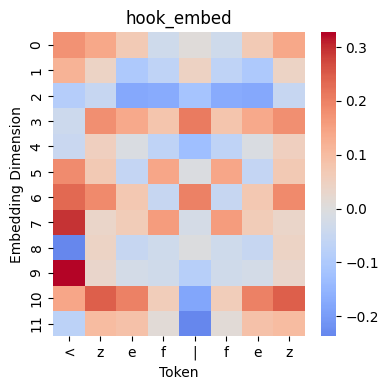

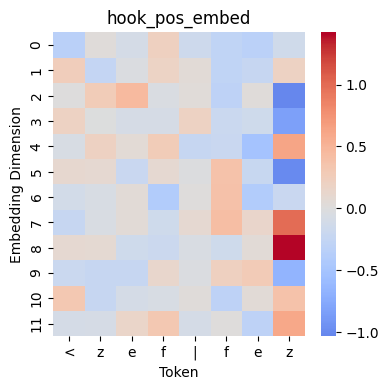

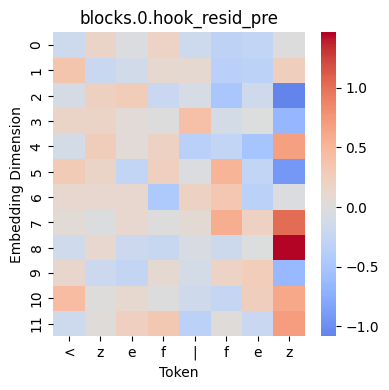

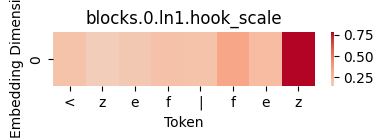

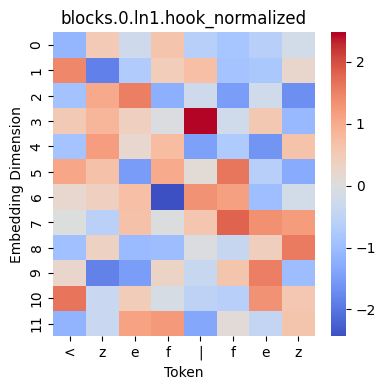

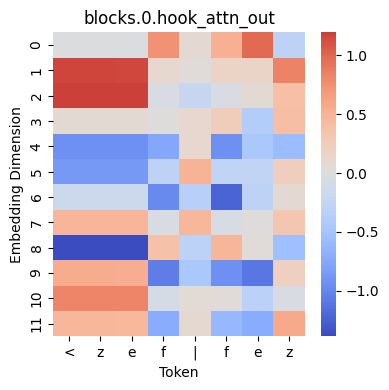

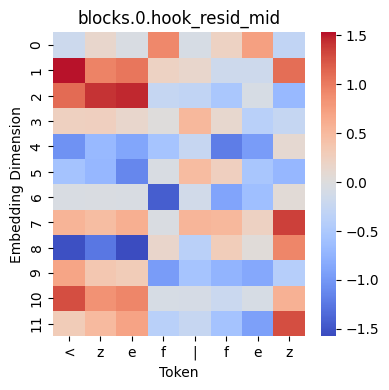

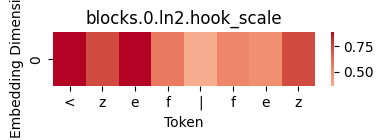

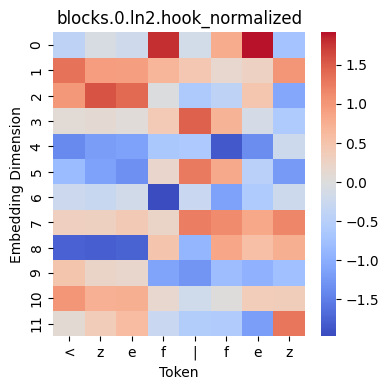

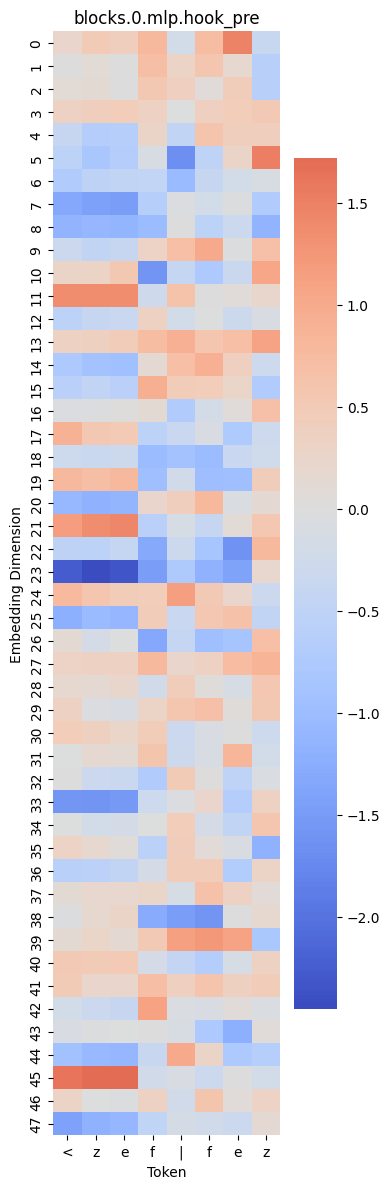

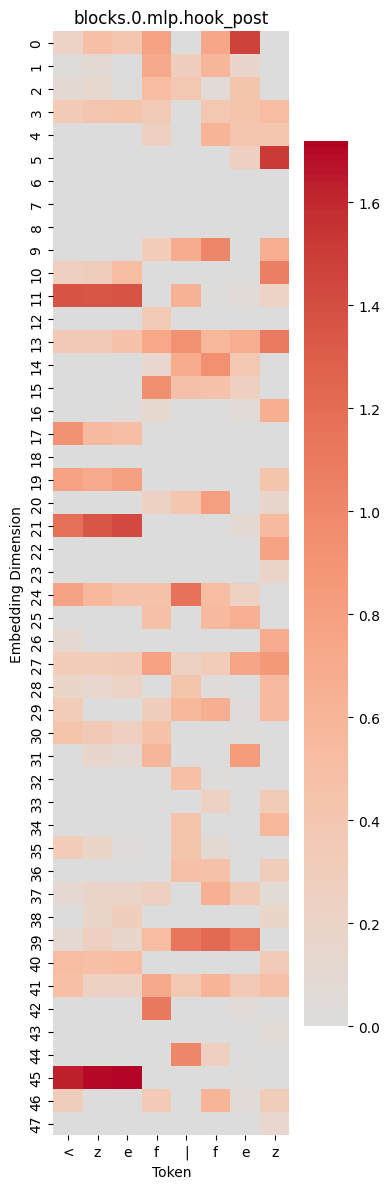

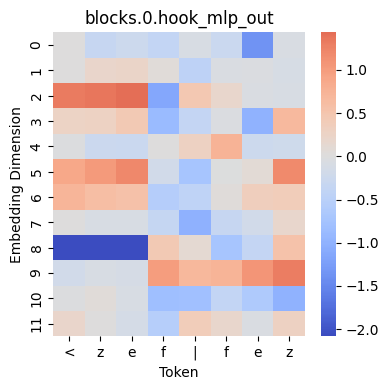

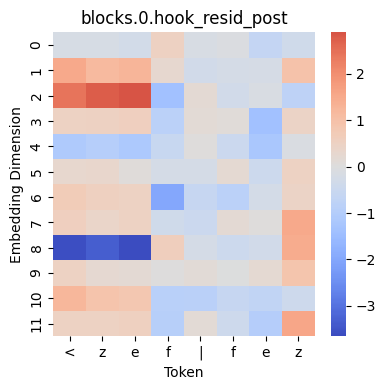

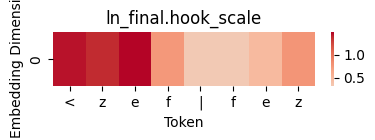

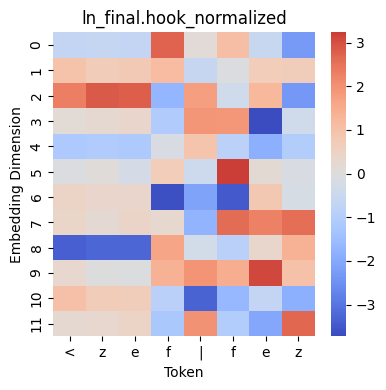

In [70]:
def plot_cache_activation(
    cache: transformer_lens.ActivationCache,
    cache_key: str,
    input_tokens_as_strings: list[str],
) -> None:

    activations = first_batch(cache[cache_key])

    figsize = (4, 4)

    # make figure smaller for vectors
    if activations.shape[-1] == 1:
        figsize = (4, 1.5)

    # for larger activations like MLP, allow it to be taller
    elif activations.shape[-1] > 20:
        figsize = (4, 12)

    plt.figure(figsize=figsize)

    sns.heatmap(
        activations.cpu().numpy().T,
        cmap="coolwarm",
        center=0,
        xticklabels=input_tokens_as_strings,
    )

    plt.title(cache_key)

    # TODO(bschoen): Allow specifying this
    #
    plt.ylabel("Embedding Dimension")
    plt.xlabel("Token")

    plt.tight_layout()
    plt.show()


for cache_key in [
    "hook_embed",
    "hook_pos_embed",
    "blocks.0.hook_resid_pre",
    "blocks.0.ln1.hook_scale",
    "blocks.0.ln1.hook_normalized",
    "blocks.0.hook_attn_out",
    "blocks.0.hook_resid_mid",
    "blocks.0.ln2.hook_scale",
    "blocks.0.ln2.hook_normalized",
    "blocks.0.mlp.hook_pre",
    "blocks.0.mlp.hook_post",
    "blocks.0.hook_mlp_out",
    "blocks.0.hook_resid_post",
    "ln_final.hook_scale",
    "ln_final.hook_normalized",
]:

    plot_cache_activation(
        cache=cache,
        cache_key=cache_key,
        input_tokens_as_strings=input_tokens_as_strings,
    )

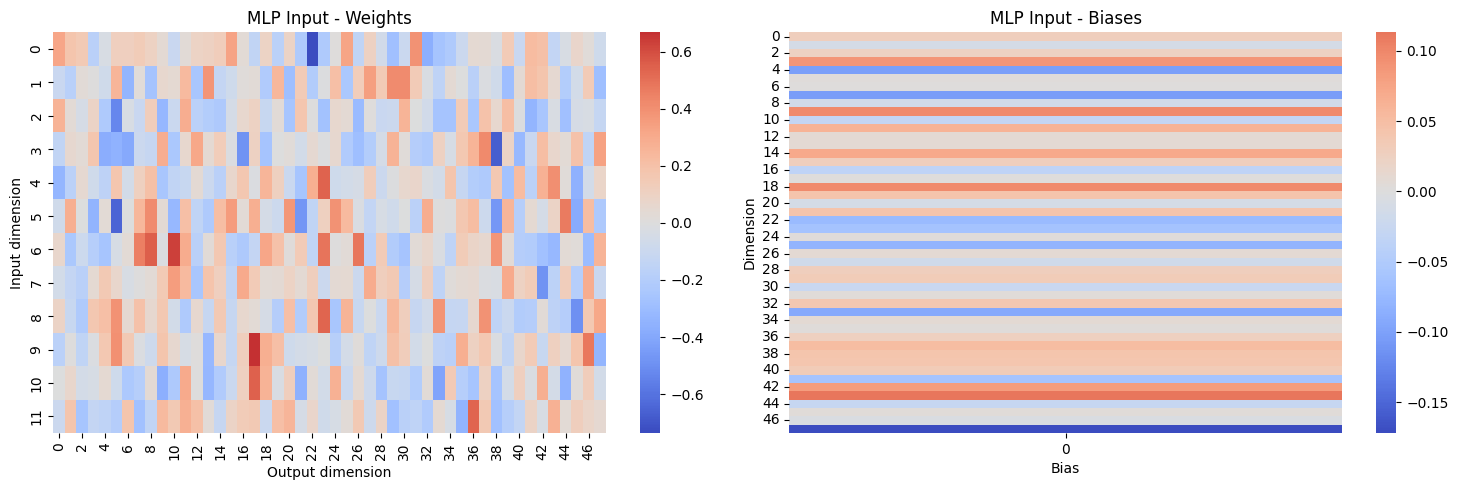

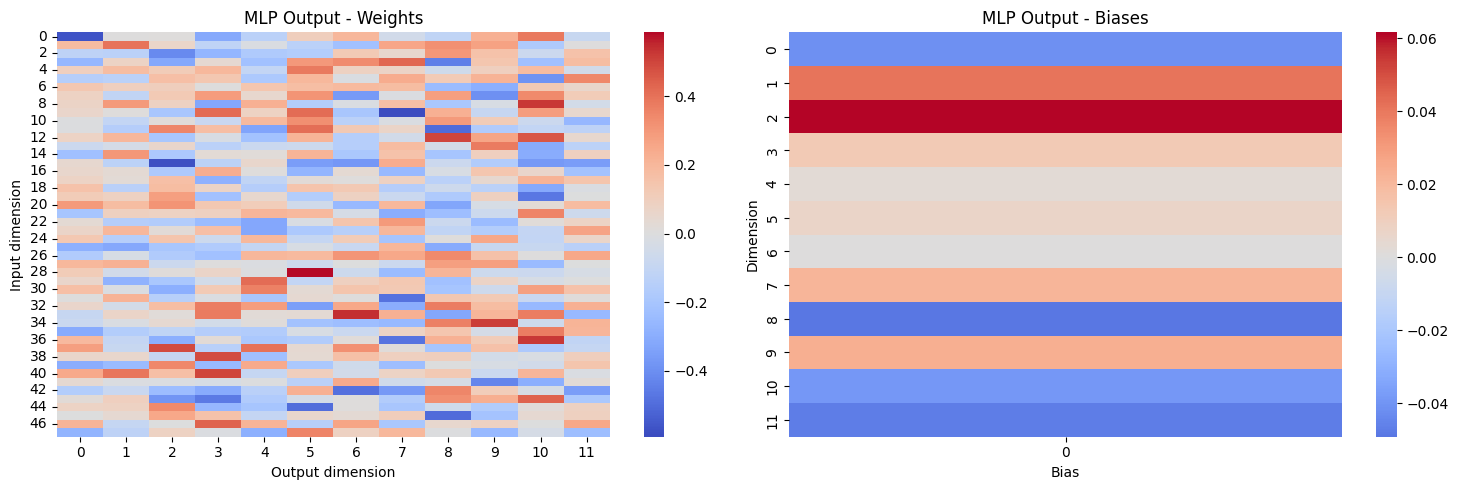

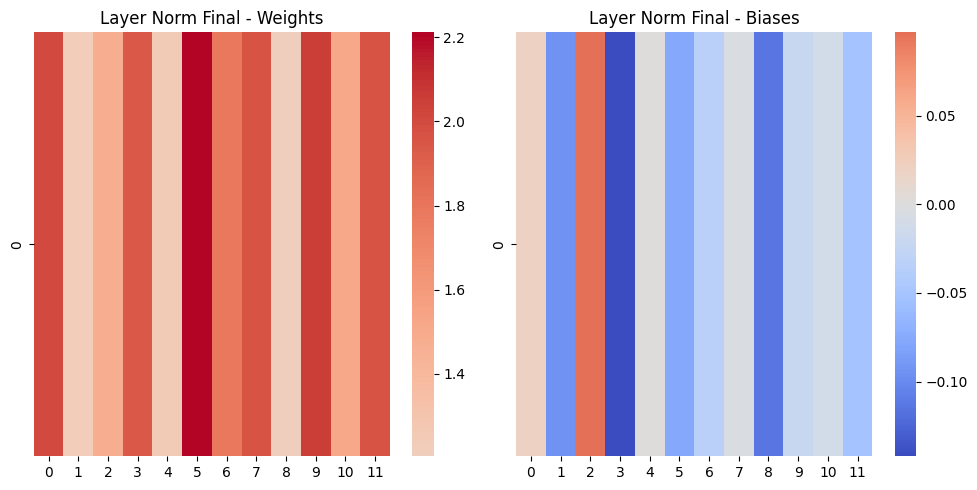

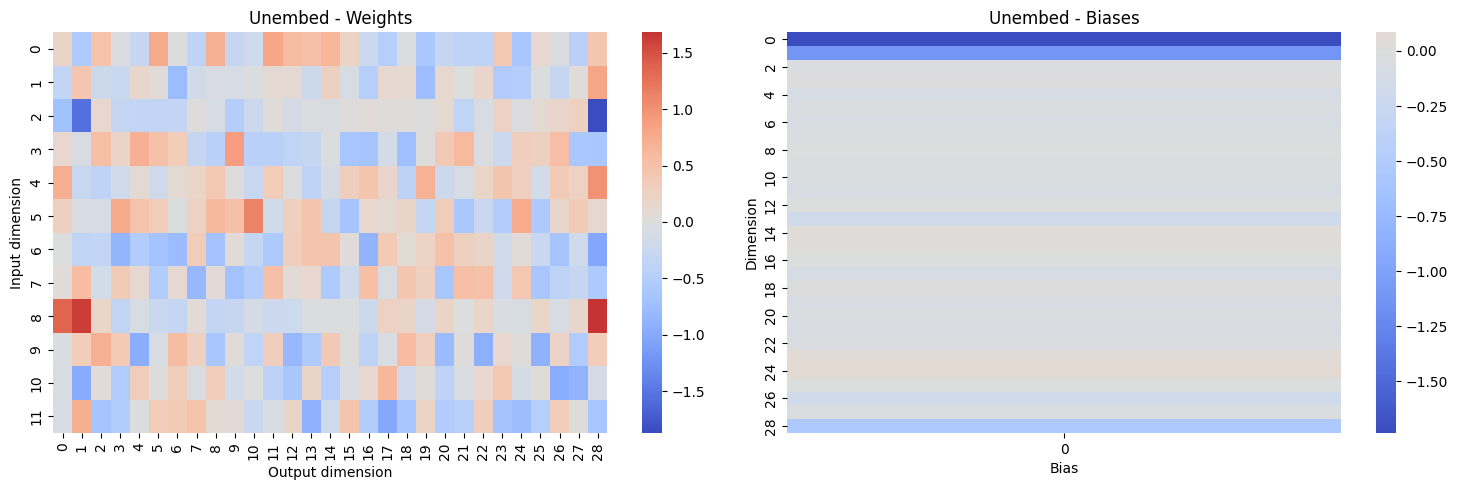

In [72]:
# visualize MLP

import matplotlib.pyplot as plt
import seaborn as sns
import torch


def plot_mlp_weights_and_biases(model):
    # Function to plot heatmaps for MLP weights and biases

    def plot_weight_bias_pair(weight, bias, title):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        sns.heatmap(weight.detach().cpu().numpy(), ax=ax1, cmap="coolwarm", center=0)
        ax1.set_title(f"{title} - Weights")
        ax1.set_xlabel("Output dimension")
        ax1.set_ylabel("Input dimension")

        sns.heatmap(
            bias.detach().cpu().numpy().reshape(-1, 1),
            ax=ax2,
            cmap="coolwarm",
            center=0,
        )
        ax2.set_title(f"{title} - Biases")
        ax2.set_xlabel("Bias")
        ax2.set_ylabel("Dimension")

        plt.tight_layout()
        plt.show()

    # MLP weights and biases
    plot_weight_bias_pair(
        model.blocks[0].mlp.W_in, model.blocks[0].mlp.b_in, "MLP Input"
    )
    plot_weight_bias_pair(
        model.blocks[0].mlp.W_out, model.blocks[0].mlp.b_out, "MLP Output"
    )

    # Layer Norm final
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(
        model.ln_final.w.detach().cpu().numpy().reshape(1, -1),
        cmap="coolwarm",
        center=1,
    )
    plt.title("Layer Norm Final - Weights")
    plt.subplot(1, 2, 2)
    sns.heatmap(
        model.ln_final.b.detach().cpu().numpy().reshape(1, -1),
        cmap="coolwarm",
        center=0,
    )
    plt.title("Layer Norm Final - Biases")
    plt.tight_layout()
    plt.show()

    # Unembed
    plot_weight_bias_pair(model.unembed.W_U, model.unembed.b_U, "Unembed")


# Call the function
plot_mlp_weights_and_biases(model)

# Comment: Additional visualizations that could be useful:
# 1. Histograms of weight/bias distributions
# 2. 3D surface plots for weights to show patterns
# 3. Network architecture diagram with weight magnitudes represented by line thickness
# 4. Animated heatmaps showing weight changes during training

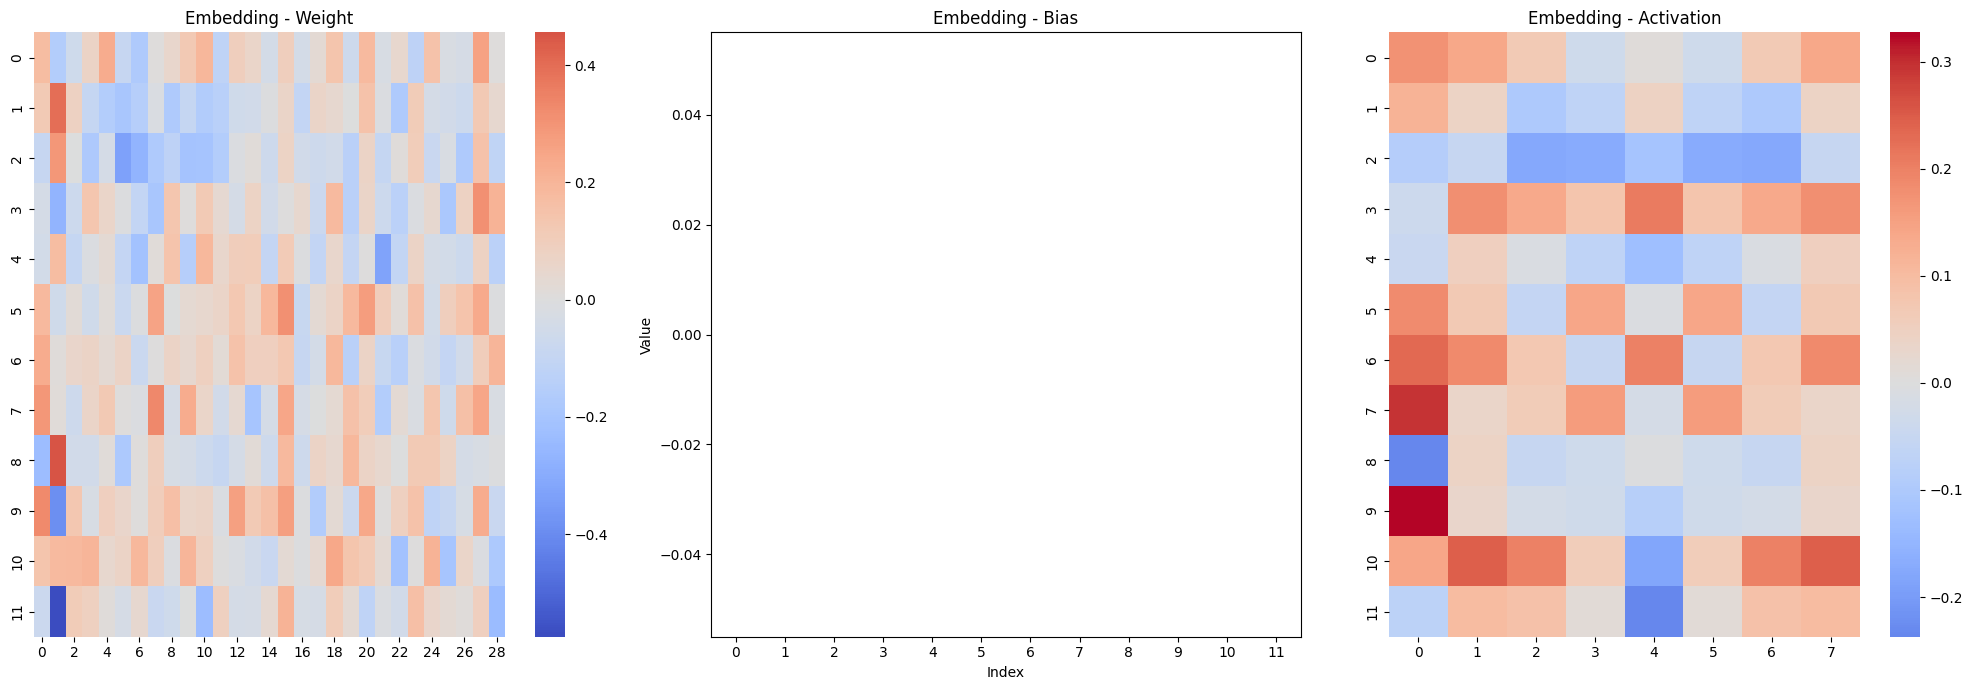

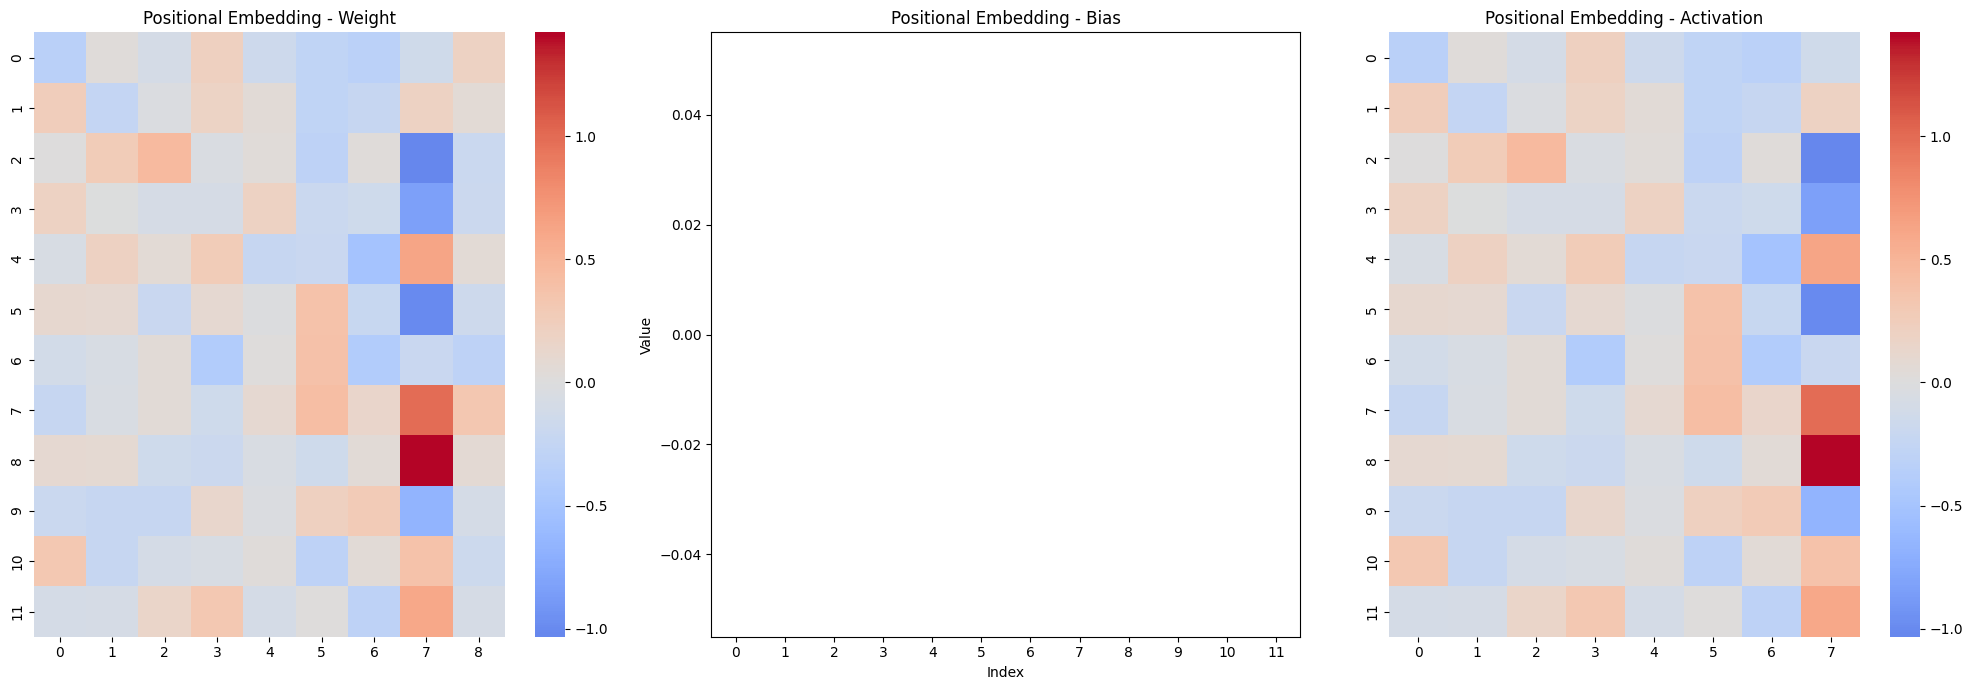

In [92]:
def plot_weight_bias_activation(
    weight,
    bias,
    activation,
    title: str,
) -> None:

    activation = first_batch(activation)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

    sns.heatmap(weight.detach().cpu().numpy().T, ax=ax1, cmap="coolwarm", center=0)
    ax1.set_title(f"{title} - Weight")

    sns.barplot(x=list(range(len(bias))), y=bias.detach().cpu().numpy(), ax=ax2)
    ax2.set_title(f"{title} - Bias")
    ax2.set_xlabel("Index")
    ax2.set_ylabel("Value")

    sns.heatmap(activation.detach().cpu().numpy().T, ax=ax3, cmap="coolwarm", center=0)
    ax3.set_title(f"{title} - Activation")

    plt.tight_layout()
    plt.show()


plot_weight_bias_activation(
    model.embed.W_E,
    torch.zeros(model.embed.W_E.shape[1]),
    cache["hook_embed"],
    "Embedding",
)
plot_weight_bias_activation(
    model.pos_embed.W_pos,
    torch.zeros(model.pos_embed.W_pos.shape[1]),
    cache["hook_pos_embed"],
    "Positional Embedding",
)

In [93]:
# TODO(bschoen): Hook residual pre?

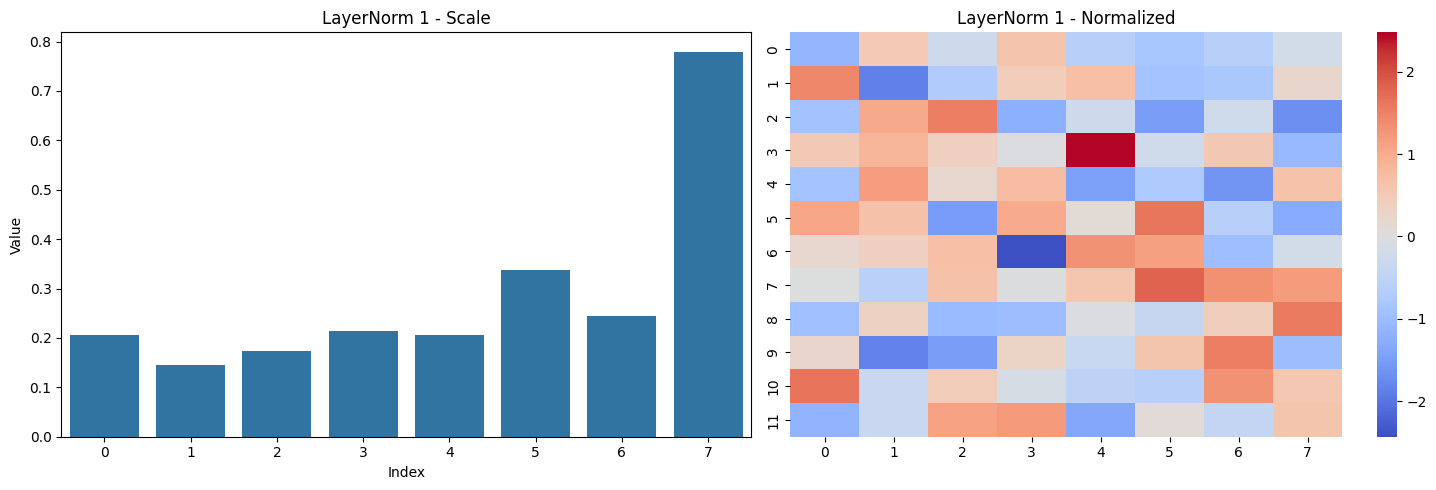

In [94]:
# Plotting LayerNorm components


def plot_layernorm(scale, normalized, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    scale = first_batch(scale)
    normalized = first_batch(normalized)

    sns.barplot(
        x=list(range(len(scale))), y=scale.squeeze().detach().cpu().numpy(), ax=ax1
    )
    ax1.set_title(f"{title} - Scale")
    ax1.set_xlabel("Index")
    ax1.set_ylabel("Value")

    sns.heatmap(normalized.detach().cpu().numpy().T, ax=ax2, cmap="coolwarm", center=0)
    ax2.set_title(f"{title} - Normalized")

    plt.tight_layout()
    plt.show()


plot_layernorm(
    cache["blocks.0.ln1.hook_scale"],
    cache["blocks.0.ln1.hook_normalized"],
    "LayerNorm 1",
)

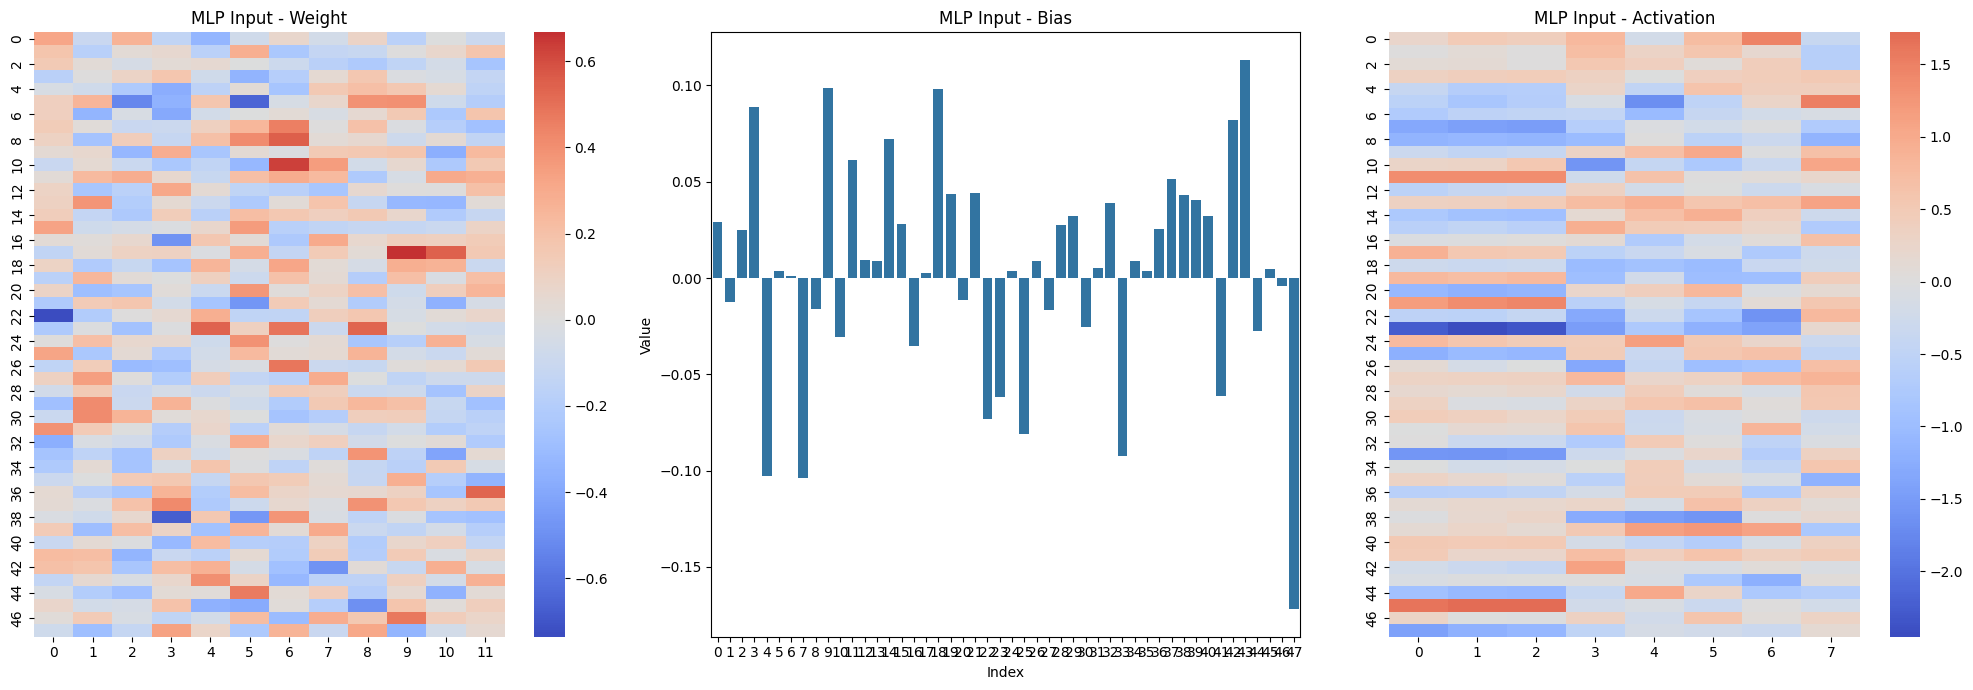

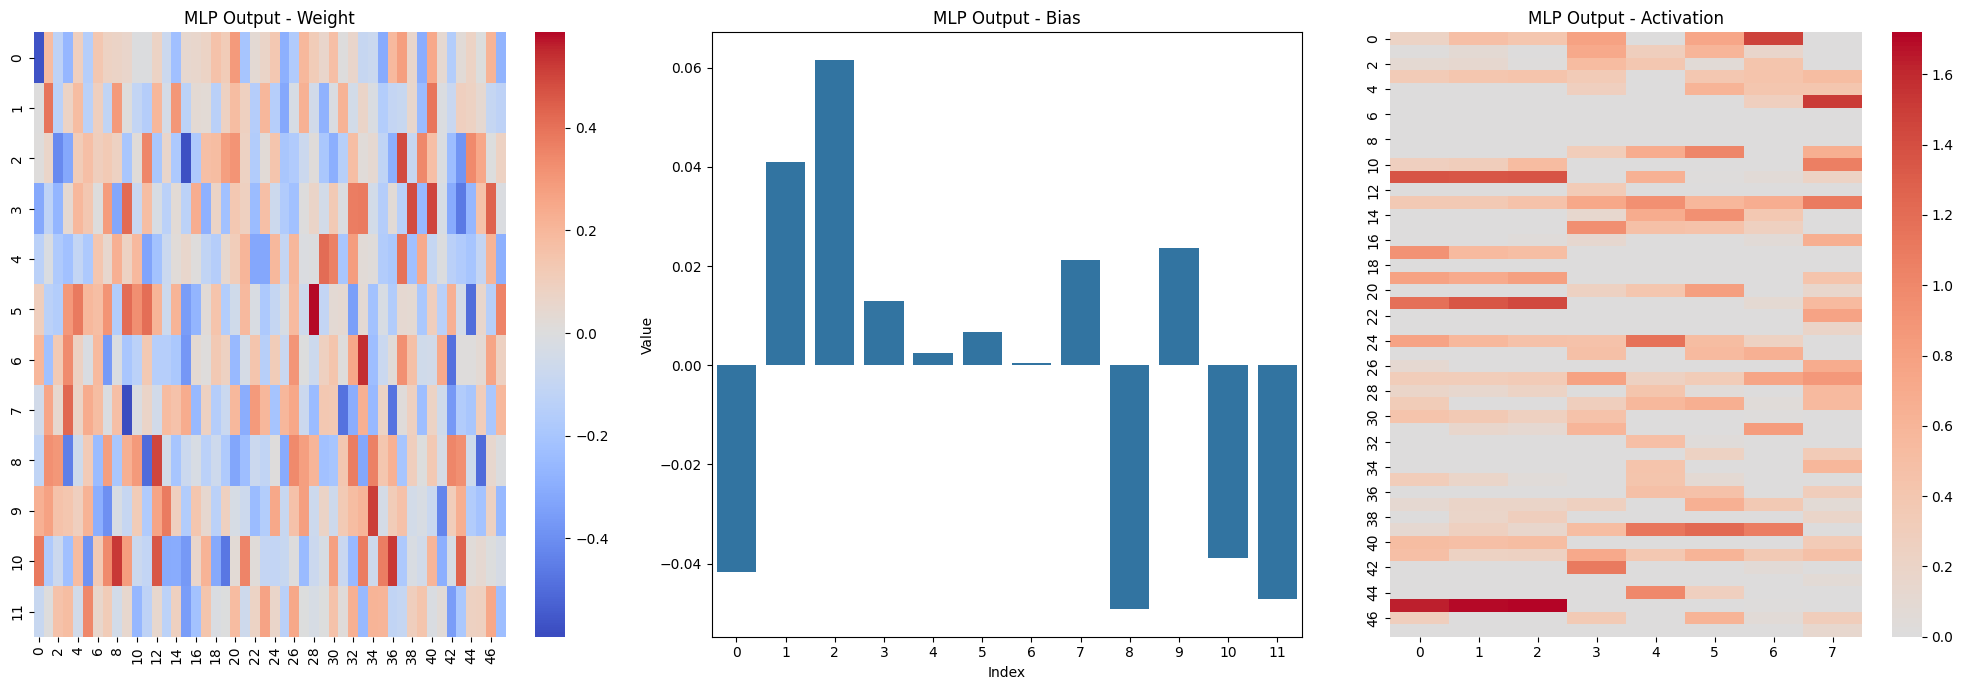

In [95]:
# Plotting MLP components
plot_weight_bias_activation(
    model.blocks[0].mlp.W_in,
    model.blocks[0].mlp.b_in,
    cache["blocks.0.mlp.hook_pre"],
    "MLP Input",
)
plot_weight_bias_activation(
    model.blocks[0].mlp.W_out,
    model.blocks[0].mlp.b_out,
    cache["blocks.0.mlp.hook_post"],
    "MLP Output",
)

#### circuitsvis.activations

In [56]:
# tokens := List of tokens if single sample (e.g. `["A", "person"]`) or list of lists of tokens (e.g. `[[["A", "person"], ["is", "walking"]]]`)
# activations := Activations of the shape [tokens x layers x neurons] if single sample or list of [tokens x layers x neurons] if multiple samples

# take first batch for now
activations = cache["blocks.0.hook_mlp_out"][0]
print(f"{activations.shape=}")

# reshape [tokens x neurons] -> [tokens x 1 x neurons]
#  - `-1` means to automatically infer the size of the last dimension
activations_view = activations.view(len(input_tokens), cfg.n_layers, -1)

print(f"{activations_view.shape=}")

# convert to strings (which this function expects)
input_tokens_as_strings = [token_to_string(x.item()) for x in input_tokens]

# TODO(bschoen): Is there a way to essentially stack these? Claude can probably give the React for that

# so here we can visualize activations for a `torch.Size([1, 8, 16])`, which is most
# of them since this is the size of the embedding dimension
circuitsvis.activations.text_neuron_activations(
    tokens=[token_to_string(x.item()) for x in input_tokens],
    activations=activations_view,
)

activations.shape=torch.Size([8, 12])
activations_view.shape=torch.Size([8, 1, 12])


#### circuitsvis.attention

In [57]:
# tokens: List of tokens (e.g. `["A", "person"]`). Must be the same length as the list of values.
# attention: Attention head activations of the shape [dest_tokens x src_tokens]
# max_value: Maximum value. Used to determine how dark the token color is when positive (i.e. based on how close it is to the maximum value).
# min_value: Minimum value. Used to determine how dark the token color is when negative (i.e. based on how close it is to the minimum value).
# negative_color: Color for negative values
# positive_color: Color for positive values.
# show_axis_labels: Whether to show axis labels.
# mask_upper_tri: Whether or not to mask the upper triangular portion of the attention patterns. Should be true for causal attention, false for bidirectional attention.


# take first batch
# ex: torch.Size([4, 8, 8]) -> [n_heads, n_ctx, n_ctx]
# note: `blocks.0.attn.hook_attn_scores` is too early (not normalized?)
attention = cache["blocks.0.attn.hook_pattern"][0]

print(f"{attention.shape=}")

circuitsvis.attention.attention_heads(
    tokens=input_tokens_as_strings,
    attention=attention,
    max_value=1,
    min_value=-1,
    negative_color="blue",
    positive_color="red",
    mask_upper_tri=True,
)

attention.shape=torch.Size([1, 8, 8])


#### circuitsvis.logits

In [58]:
# this is the normal one we usually show, i.e.
# cv.logits.token_log_probs(
#     token_indices=input_tokens,
#     log_probs=log_probs,
#     to_string=token_to_string,
# )

#### circuitsvis.tokens

In [59]:
# for example, we'll look at each

# take first batch, ex: torch.Size([8, 16])
pos_embed = cache["hook_pos_embed"][0]

# low level function for coloring tokens according to single value
for i in range(cfg.d_model):
    display(
        circuitsvis.tokens.colored_tokens(
            tokens=input_tokens_as_strings,
            values=pos_embed[:, i],
            negative_color="blue",
            positive_color="red",
        )
    )

    # only display a few for example
    # if i >= 2:
    #    break

In [33]:
# take first batch
# ex: torch.size([8, 16]) = [n_ctx, d_model]
attention_out = cache["blocks.0.hook_attn_out"][0]

circuitsvis.tokens.colored_tokens_multi(
    tokens=input_tokens_as_strings,
    values=attention_out,
    labels=[str(x) for x in range(cfg.d_model)],
)

In [34]:
circuitsvis.tokens.visualize_model_performance(
    tokens=input_tokens,
    str_tokens=input_tokens_as_strings,
    logits=logits,
)

#### circuitsvis.topk_samples

In [35]:
circuitsvis.topk_samples.topk_samples??

Signature:
circuitsvis.topk_samples.topk_samples(
    tokens: List[List[List[List[str]]]],
    activations: List[List[List[List[float]]]],
    zeroth_dimension_name: Optional[str] = 'Layer',
    first_dimension_name: Optional[str] = 'Neuron',
    zeroth_dimension_labels: Optional[List[str]] = None,
    first_dimension_labels: Optional[List[str]] = None,
) -> circuitsvis.utils.render.RenderedHTML
Source:   
def topk_samples(
    tokens: List[List[List[List[str]]]],
    activations: List[List[List[List[float]]]],
    zeroth_dimension_name: Optional[str] = "Layer",
    first_dimension_name: Optional[str] = "Neuron",
    zeroth_dimension_labels: Optional[List[str]] = None,
    first_dimension_labels: Optional[List[str]] = None,
) -> RenderedHTML:
    """List of samples in descending order of max token activation value for the
    selected layer and neuron (or whatever other dimension names are specified).

    Args:
        tokens: List of tokens of shape [layers x neurons x samples x toke

#### circuitsvis.topk_tokens

In [36]:
circuitsvis.topk_tokens.topk_tokens??

Signature:
circuitsvis.topk_tokens.topk_tokens(
    tokens: List[List[str]],
    activations: List[numpy.ndarray],
    max_k: int = 10,
    first_dimension_name: str = 'Layer',
    third_dimension_name: str = 'Neuron',
    sample_labels: Optional[List[str]] = None,
    first_dimension_labels: Optional[List[str]] = None,
) -> circuitsvis.utils.render.RenderedHTML
Source:   
def topk_tokens(
    tokens: List[List[str]],
    activations: List[np.ndarray],  # np.ndarray: [n_layers, n_tokens, n_neurons]
    max_k: int = 10,
    first_dimension_name: str = "Layer",
    third_dimension_name: str = "Neuron",
    sample_labels: Optional[List[str]] = None,
    first_dimension_labels: Optional[List[str]] = None,
) -> RenderedHTML:
    """Show a table of the topk and bottomk activations.

    The columns correspond to the given third_dimension_name.

    Includes drop-downs for all dimensions as well as options to choose the number of columns to show.

    Note that we can't set labels for the thi

## SAE

In [37]:
for layer_index in range(cfg.n_layers):
    imshow(
        transformer_lens.utils.to_numpy(cache["attn", layer_index].mean([0, 1])),
        title=f"Layer {layer_index} Attention Pattern",
        height=400,
        width=400,
    )

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import dataclasses

Loss = Float32[torch.Tensor, ""]
MSELoss = Float32[torch.Tensor, ""]
WeightedSparsityLoss = Float32[torch.Tensor, ""]

Logits = Float32[torch.Tensor, "n_ctx d_vocab"]
BatchedLogits = Float32[torch.Tensor, "batch n_ctx d_vocab"]

ModelActivations = Float32[torch.Tensor, "n_ctx d_model"]
BatchedModelActivations = Float32[torch.Tensor, "batch n_ctx d_model"]

FlattenedModelActivations = Float32[torch.Tensor, "d_sae_in"]

BatchedFlattenedModelActivations = Float32[torch.Tensor, "batch d_sae_in"]
BatchedSAEActivations = Float32[torch.Tensor, "batch d_sae_model"]


@dataclasses.dataclass
class SAEOutput:
    sae_activations: BatchedSAEActivations
    reconstructed_model_activations: BatchedFlattenedModelActivations


def sparse_loss_kl_divergence(
    flattened_model_activations: BatchedFlattenedModelActivations,
    sae_output: SAEOutput,
    sparsity_target: float,
    sparsity_weight: float,
    epsilon: float = 1e-7,
) -> tuple[Loss, MSELoss, WeightedSparsityLoss]:

    # same as dense loss (this is constant?)
    mse_loss = F.mse_loss(
        sae_output.reconstructed_model_activations,
        flattened_model_activations,
    )

    # KL divergence for sparsity
    avg_activation = torch.mean(sae_output.sae_activations, dim=0)

    # print(f'[pre-clamping] {avg_activation=}')

    # Add epsilon for numerical stability
    avg_activation = torch.clamp(avg_activation, epsilon, 1 - epsilon)

    kl_div = sparsity_target * torch.log(sparsity_target / avg_activation) + (
        1 - sparsity_target
    ) * torch.log((1 - sparsity_target) / (1 - avg_activation))
    kl_div = torch.sum(kl_div)

    # `sparsity_weight` decides how much we weight `KL-Divergence`
    sparsity_penalty = sparsity_weight * kl_div

    print(
        f"[sparse_loss] {mse_loss=}, {avg_activation=}, {kl_div.item()}, {sparsity_penalty=}"
    )

    return mse_loss + sparsity_penalty, mse_loss, sparsity_penalty

In [39]:
def sparse_loss_l1_norm(
    flattened_model_activations: BatchedFlattenedModelActivations,
    sae_output: SAEOutput,
    sparsity_weight: float,
) -> tuple[Loss, MSELoss, WeightedSparsityLoss]:

    # Reconstruction loss (Mean Squared Error)
    mse_loss = F.mse_loss(
        sae_output.reconstructed_model_activations,
        flattened_model_activations,
    )

    # L1 sparsity penalty
    l1_penalty = torch.mean(torch.abs(sae_output.sae_activations))

    sparsity_penalty = sparsity_weight * l1_penalty

    # Total loss
    total_loss = mse_loss + sparsity_penalty

    return total_loss, mse_loss, sparsity_penalty

In [40]:
import dataclasses


@dataclasses.dataclass
class SparseAutoencoderConfig:
    d_in: int
    d_model: int


# TODO(bschoen): Start using the config pattern, it stays typesafe and allows
#                easy logging to things like wandb
class SparseAutoencoder(nn.Module):
    def __init__(
        self,
        cfg: SparseAutoencoderConfig,
    ) -> None:

        print(f"Creating SparseAutoencoder with {cfg}")

        super(SparseAutoencoder, self).__init__()

        self.d_in = cfg.d_in
        self.d_model = cfg.d_model

        self.encoder = nn.Linear(cfg.d_in, cfg.d_model)
        self.decoder = nn.Linear(cfg.d_model, cfg.d_in)

    def forward(
        self,
        x: BatchedFlattenedModelActivations,
    ) -> SAEOutput:

        # TODO(bschoen): Which activation function should we use?
        encoded = F.gelu(self.encoder(x))

        decoded = self.decoder(encoded)

        return SAEOutput(
            sae_activations=encoded,
            reconstructed_model_activations=decoded,
        )

In [41]:
import lightning.pytorch


@dataclasses.dataclass
class LightningSparseAutoencoderConfig:

    model_config: transformer_lens.HookedTransformerConfig
    sae_config: SparseAutoencoderConfig
    learning_rate: float
    sparsity_weight: float


# note: this kind of lightning adapter is a common pattern: https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#starter-example
class LightningSparseAutoencoder(lightning.pytorch.LightningModule):
    def __init__(
        self,
        cfg: LightningSparseAutoencoderConfig,
    ) -> None:

        super(LightningSparseAutoencoder, self).__init__()

        self.model = transformer_lens.HookedTransformer(cfg=cfg.model_config)
        self.sae = SparseAutoencoder(cfg=cfg.sae_config)
        self.cfg = cfg

    def forward(self, inputs, target):
        return self.model(inputs, target)

    def training_step(self, batch, batch_idx: int) -> Loss:
        inputs, target = batch

        self.model
        output = self(inputs, target)
        loss = torch.nn.functional.cr(output, target.view(-1))
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.model.parameters(), lr=0.1)

In [42]:
hook_id = "blocks.0.hook_mlp_out"

cache[hook_id].shape

torch.Size([1, 8, 12])

In [43]:
# Training loop
sae_num_epochs = 100000
sae_expansion_factor = 4

learning_rate = 1e-4

# both arbitrary for now
# - Start small: A common approach is to begin with a relatively small sparsity weight,
#                typically in the range of 1e-5 to 1e-3. This allows the model to
#                learn meaningful representations before enforcing strong sparsity
#                constraints.
sparsity_weight: float = 1e-3  # Weight of the sparsity loss in the total loss
sparsity_target: float = 0.05  # Target average activation of hidden neurons

print(f"Training SAE for {hook_id}...")
sae_d_in = (cfg.n_ctx - 1) * cfg.d_model  # -1 since not predicting first token
sae_d_model = sae_d_in * sae_expansion_factor

sae_cfg = SparseAutoencoderConfig(
    d_in=sae_d_in,
    d_model=sae_d_model,
)

sae_model = SparseAutoencoder(cfg=sae_cfg)
sae_model.to(device)

sae_optimizer = optim.Adam(sae_model.parameters(), lr=learning_rate)

wandb.init(
    project="toy-problem-hooked-transformer-sae",
    config={
        "sae_num_epochs": sae_num_epochs,
        "sae_expansion_factor": sae_expansion_factor,
        "learning_rate": learning_rate,
        "sparsity_weight": sparsity_weight,
        "sparsity_target": sparsity_target,
        "sae_d_in": sae_d_in,
        "sae_d_model": sae_d_model,
        "hook_id": hook_id,
    },
)

# put model itself into eval mode so doesn't change
model.eval()

# go through the training data again, this time training the sae on the activations
for epoch, batch in tqdm.tqdm(
    zip(
        range(sae_num_epochs),
        itertools.cycle(train_loader),
    )
):

    tokens, target = batch

    tokens, target = tokens.to(device), target.to(device)

    # run through the model (with cache) to get the activations
    logits, cache = model.run_with_cache(tokens)

    # ex: torch.Size([4, 8, 16])
    activations = cache[hook_id]

    # ex: torch.Size([4, 128])
    flattened_activations = activations.reshape(activations.size(0), -1)

    sae_optimizer.zero_grad()

    # now the SAE model is given the *activations*
    sae_output = sae_model.forward(flattened_activations)

    # compute loss

    # total_loss, reconstruction_loss, weighted_sparsity_loss = sparse_loss_kl_divergence(
    #    flattened_activations,
    #    sae_output,
    #    sparsity_target=sparsity_target,
    #    sparsity_weight=sparsity_weight,
    # )

    total_loss, reconstruction_loss, weighted_sparsity_loss = sparse_loss_l1_norm(
        flattened_model_activations=flattened_activations,
        sae_output=sae_output,
        sparsity_weight=sparsity_weight,
    )

    total_loss.backward()

    sae_optimizer.step()

    if epoch % 500 == 0:
        print(
            f"Step {epoch}, "
            f"Total Loss: {total_loss.item():.6f}, "
            f"Reconstruction Loss: {reconstruction_loss.item():.6f}, "
            f"Sparsity Loss: {weighted_sparsity_loss.item():.6f}",
        )

        wandb.log(
            {
                "epoch": epoch,
                "total_loss": total_loss.item(),
                "reconstruction_loss": reconstruction_loss.item(),
                "weighted_sparsity_loss": weighted_sparsity_loss.item(),
            }
        )

wandb.finish()

Training SAE for blocks.0.hook_mlp_out...
Creating SparseAutoencoder with SparseAutoencoderConfig(d_in=96, d_model=384)


24it [00:00, 71.44it/s]

Step 0, Total Loss: 0.478086, Reconstruction Loss: 0.477916, Sparsity Loss: 0.000170


541it [00:02, 241.36it/s]

Step 500, Total Loss: 0.046793, Reconstruction Loss: 0.046474, Sparsity Loss: 0.000318


1035it [00:04, 242.23it/s]

Step 1000, Total Loss: 0.016404, Reconstruction Loss: 0.016002, Sparsity Loss: 0.000401


1527it [00:07, 223.27it/s]

Step 1500, Total Loss: 0.011081, Reconstruction Loss: 0.010644, Sparsity Loss: 0.000437


2029it [00:09, 214.14it/s]

Step 2000, Total Loss: 0.007650, Reconstruction Loss: 0.007187, Sparsity Loss: 0.000464


2529it [00:11, 199.61it/s]

Step 2500, Total Loss: 0.004770, Reconstruction Loss: 0.004301, Sparsity Loss: 0.000469


3033it [00:13, 237.06it/s]

Step 3000, Total Loss: 0.004486, Reconstruction Loss: 0.003981, Sparsity Loss: 0.000505


3542it [00:16, 230.45it/s]

Step 3500, Total Loss: 0.003386, Reconstruction Loss: 0.002876, Sparsity Loss: 0.000510


4042it [00:18, 248.37it/s]

Step 4000, Total Loss: 0.002996, Reconstruction Loss: 0.002477, Sparsity Loss: 0.000519


4528it [00:20, 252.51it/s]

Step 4500, Total Loss: 0.002489, Reconstruction Loss: 0.002023, Sparsity Loss: 0.000466


5020it [00:22, 219.57it/s]

Step 5000, Total Loss: 0.002118, Reconstruction Loss: 0.001575, Sparsity Loss: 0.000543


5529it [00:24, 244.38it/s]

Step 5500, Total Loss: 0.001777, Reconstruction Loss: 0.001287, Sparsity Loss: 0.000490


6020it [00:26, 221.74it/s]

Step 6000, Total Loss: 0.001420, Reconstruction Loss: 0.000894, Sparsity Loss: 0.000526


6530it [00:28, 208.88it/s]

Step 6500, Total Loss: 0.001421, Reconstruction Loss: 0.000926, Sparsity Loss: 0.000495


7035it [00:30, 250.27it/s]

Step 7000, Total Loss: 0.001211, Reconstruction Loss: 0.000716, Sparsity Loss: 0.000494


7527it [00:32, 247.41it/s]

Step 7500, Total Loss: 0.001031, Reconstruction Loss: 0.000543, Sparsity Loss: 0.000488


8036it [00:34, 235.22it/s]

Step 8000, Total Loss: 0.001115, Reconstruction Loss: 0.000643, Sparsity Loss: 0.000472


8546it [00:36, 248.65it/s]

Step 8500, Total Loss: 0.000885, Reconstruction Loss: 0.000420, Sparsity Loss: 0.000465


9049it [00:38, 240.17it/s]

Step 9000, Total Loss: 0.000893, Reconstruction Loss: 0.000433, Sparsity Loss: 0.000461


9527it [00:40, 199.64it/s]

Step 9500, Total Loss: 0.000904, Reconstruction Loss: 0.000453, Sparsity Loss: 0.000451


10020it [00:43, 181.50it/s]

Step 10000, Total Loss: 0.000951, Reconstruction Loss: 0.000524, Sparsity Loss: 0.000427


10537it [00:45, 251.11it/s]

Step 10500, Total Loss: 0.000838, Reconstruction Loss: 0.000417, Sparsity Loss: 0.000420


11046it [00:47, 243.79it/s]

Step 11000, Total Loss: 0.000834, Reconstruction Loss: 0.000433, Sparsity Loss: 0.000401


11525it [00:49, 233.23it/s]

Step 11500, Total Loss: 0.000712, Reconstruction Loss: 0.000312, Sparsity Loss: 0.000400


12035it [00:51, 210.65it/s]

Step 12000, Total Loss: 0.000741, Reconstruction Loss: 0.000345, Sparsity Loss: 0.000396


12529it [00:54, 230.76it/s]


Step 12500, Total Loss: 0.000644, Reconstruction Loss: 0.000275, Sparsity Loss: 0.000369


KeyboardInterrupt: 

#### Dictionary Learning Implementation

See [simple_dictionary_learning.ipynb](simple_dictionary_learning.ipynb) for a details

#### Extracting the learned dictionary

In [ ]:
# Creating SparseAutoencoder with d_in=128, d_model=512, sparsity_target=0.05
dictionary: Float32[torch.Tensor, "sae_hidden sae_in"] = (
    sae_model.encoder.weight.detach()
)

# ex: Dictionary shape: torch.Size([512, 128])
print(f"Dictionary shape: {dictionary.shape}")

In [ ]:
# Reshape dictionary elements to match original activation shape
# (essentially `unflatting`)
reshaped_dictionary = dictionary.reshape(sae_d_model, (cfg.n_ctx - 1), cfg.d_model)

# Motivation: Extract the learned features (dictionary elements) from the encoder weights
# ex: Dictionary shape: torch.Size([512, 8, 16])
print(f"Dictionary shape: {reshaped_dictionary.shape}")

In [ ]:
# It's always worth checking this sort of thing when you do this by hand
# to check that you haven't got the wrong site, or are missing a
# scaling factor or something like this.
#
# This is like the overfitting thing

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# let's look at an example batch from `test`

# set both to eval mode
model.eval()
sae_model.eval()

# grab something from the test batch
example_batch = next(iter(test_loader))

x, y = example_batch

_, cache = model.run_with_cache(x)

activations = cache[hook_id]

print(f"Activations shape: {activations.shape}")

# flatten it
flattened_activations = activations.reshape(activations.size(0), -1)

print(f"{flattened_activations.shape=}")

sae_outputs = sae_model(flattened_activations)

print(f"{sae_outputs.sae_activations.shape=}")
print(f"{sae_outputs.reconstructed_model_activations.shape=}")

# now we can get the dictionary
dictionary = sae_model.encoder.weight.detach()

print(f"Dictionary shape: {dictionary.shape}")

# now we can get the sparse coefficients
alpha = dictionary @ flattened_activations.T

In [ ]:
# good, 0.995, basically all the variance is explained by our SAE
numerator = torch.mean(
    (sae_outputs.reconstructed_model_activations[:, 1:] - flattened_activations[:, 1:])
    ** 2
)
denominator = flattened_activations[:, 1:].to(torch.float32).var()

explained_variance = 1 - (numerator / denominator)

print(f"{explained_variance.item()=:.4f}")

# TODO(bschoen): Why did people usually use `dim=0`?
#
# note: does 0.0846 here mean that 8.46% of the activations are non-zero? (on average)
torch.mean(torch.abs(sae_outputs.sae_activations))

In [ ]:
# Let's analyze the relationship between SAE activations and input features

# TODO(bschoen): Oh `imshow` is huge here!

# 1. Visualize the dictionary (encoder weights)
plt.figure(figsize=(12, 8))
plt.imshow(dictionary.cpu().T, aspect="auto", cmap="RdBu_r")
plt.colorbar()
plt.title("SAE Dictionary (Encoder Weights)")
plt.xlabel("Dictionary Elements")
plt.ylabel("Input Features")
plt.show()

In [ ]:
# 2. Find the most active neurons for each input
top_k = 5  # Number of top activations to consider
top_activations = torch.topk(sae_outputs.sae_activations, k=top_k, dim=1)

In [ ]:
print(f"{sae_outputs.sae_activations.shape=}")
print(f"{top_activations.values.shape=}")

In [ ]:
# ex: 51 and 410 show up a lot
top_activations

In [ ]:
# 3. Analyze feature importance for each neuron
feature_importance = torch.abs(dictionary).sum(dim=1)
top_features = torch.topk(feature_importance, k=10)

print(f"{dictionary.shape=}")
print(f"{feature_importance.shape=}")
print(f"{top_features.values.shape=}")
print(f"{top_features.indices.shape=}")

top_features

In [ ]:
print("\nTop 10 most important neurons:")
for i, (value, index) in enumerate(
    zip(top_features.values.tolist(), top_features.indices.tolist())
):
    print(f"Neuron {index}:\t{value:.4f}")

In [ ]:
top_features.values.tolist()

In [ ]:
top_features.indices.tolist()

In [ ]:
# 4. Visualize activations for a few examples

# first look at a single batch
sae_activations = sae_outputs.sae_activations[0].detach().cpu()

print(f"{sae_activations.shape=}")

plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)

# Look at a single batch
plt.bar(range(sae_activations.shape[0]), sae_activations)

plt.title(f"SAE Activations for Example")
plt.xlabel("Neuron")
plt.ylabel("Activation")
plt.tight_layout()
plt.show()

In [ ]:
# 5. Reconstruct input features from SAE activations
#
# Take a single batch first
reconstructed_model_activations = (
    sae_outputs.reconstructed_model_activations.detach().cpu()
)

# 6. Compare original and reconstructed features
num_features = 5

plt.figure(figsize=(15, 3 * num_features))
for i in range(num_features):
    plt.subplot(num_features, 1, i + 1)
    plt.ylim(-1, 1)  # Set y-axis range from -1 to 1
    plt.plot(flattened_activations[:, i].cpu(), label="Original", alpha=0.5)
    plt.plot(reconstructed_model_activations[:, i], label="Reconstructed", alpha=0.5)
    plt.title(f"Feature {i}: Original vs Reconstructed")
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 7. Correlation between SAE activations and input features
correlation_matrix = torch.corrcoef(
    torch.cat([sae_outputs.sae_activations, flattened_activations], dim=1).T
)
num_neurons = sae_outputs.sae_activations.shape[1]
neuron_feature_correlation = correlation_matrix[:num_neurons, num_neurons:]

plt.figure(figsize=(12, 8))
plt.imshow(
    neuron_feature_correlation.detach().cpu(),
    aspect="auto",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
)
plt.colorbar()
plt.title("Correlation between SAE Neurons and Input Features")
plt.xlabel("Input Features")
plt.ylabel("SAE Neurons")
plt.show()

In [ ]:
sae_outputs.sae_activations

In [ ]:
# collect max activations


with torch.no_grad():

    # go through the training data again, but don't cycle, no reason to go through more than once
    for batch in tqdm.tqdm(train_loader):

        tokens, target = batch

        tokens, target = tokens.to(device), target.to(device)

        # run through the model (with cache) to get the activations
        logits, cache = model.run_with_cache(tokens)

        # ex: torch.Size([4, 8, 16])
        activations = cache[hook_id]

        # ex: torch.Size([4, 128])
        flattened_activations = activations.reshape(activations.size(0), -1)

        # now the SAE model is given the *activations*
        encoded, decoded = sae_model(flattened_activations)

        sae_activations = encoded

        # sae_activations.reshape(sae_d_model, (cfg.n_ctx - 1), cfg.d_model)

        # max_activations = torch.max(encoded, dim=1)

        break

In [ ]:
alpha = sae_model.encoder.weight @ flattened_activations[0]

print(f"{alpha.shape=}")

In [ ]:
torch.mean(torch.abs(alpha))

In [ ]:
sae_activations[0].shape

In [ ]:
8 * 16